# <span style='color:red'>Problem Set 2: Working with Financial Data</span>

## Instructions:

- **Make a copy of this notebook somewhere under the root-folder *except* for the shared-folder**
  - In JHub we have read-only access to the material under /shared
  - Everything else is associated with your Dartmouth ID and so only you can see them and they are permanent
- Enter the answers on this notebook
  - In most cases, you just need to execute the code and leave the output as it is
- All of the code needed here can be found in Topic1_PythonBasics 
- In some cases, I ask you to explain something. In the cases, there is an extra markup cell (**ANSWER:**) that you can fill out 
- When you are done, select "Print..." from the File-menu and create an **HTML** version of the notebook
  - Submit this notebook through canvas
  - Please don't submit it as a notebook (.ipynb) file

# Problem 1: Magnificent Seven

### a) Download daily data from Yahoo finance for the "magnificent seven" stocks for 2024:

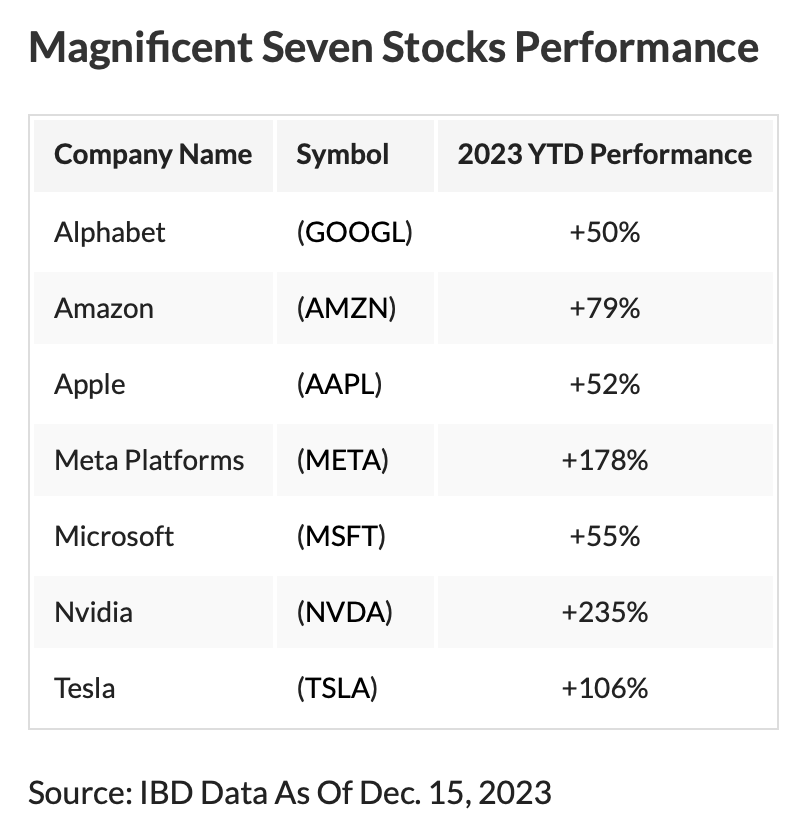

**Compute and report the average daily returns for these stocks in 2024**

Hint: if you do 

```from datetime import datetime```

you can set the start and end dates by writing

```
start_date = datetime(2023,12,30)
end_date = datetime(2024,12,31)
```
If you compute *returns* from the data that you get, it'll exactly cover 2024

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

# Define the start and end dates for the data
start_date = datetime(2023,12,31)
end_date = datetime(2024,12,31)

# Define the ticker symbols for Apple, Google, and Tesla
ticker_symbols = ['GOOGL', 'AMZN', 'AAPL', 'META', 'MSFT', 'NVDA', 'TSLA']

# Download the data for each stock
stock_data = yf.download(ticker_symbols, start=start_date, end=end_date)

# Display the first few rows of the downloaded data
stock_data.head()

returns = stock_data['Adj Close'].pct_change()
avg_returns = returns.mean()

print('Average daily returns (%)')
display(100 * avg_returns)

[*********************100%%**********************]  7 of 7 completed
Average daily returns (%)


AAPL     0.134503
AMZN     0.171527
GOOGL    0.147122
META     0.241333
MSFT     0.065271
NVDA     0.474530
TSLA     0.286161
dtype: float64

### b) What was the *median* number of shares traded -- that is, median volume -- in 2024 for these seven stocks?

Hints: 
- You have the Yahoo finance data
- Instead of picking the "Adj Close" information with .xs(), pick "Volume"
- If the resulting dataframe is called, say, df, you can compute medians by writing ```df.median()```

In [11]:
print('Median Number of Shares Traded in 2024')

stock_data['Volume'].median()

Median Number of Shares Traded in 2024


AAPL      49947900.0
AMZN      37552100.0
GOOGL     24100300.0
META      12620000.0
MSFT      19144400.0
NVDA     352994000.0
TSLA      87391700.0
dtype: float64

### c) Create a new column "magnificent" that is the return on a portfolio that invests an equal amount into each stock and rebalances daily 

Report the average daily return for this "magnificent" portfolio.

Hint: If you have a dataframe with the returns, this is *really* simple. Just like Topic2, you just need to write something like

```df['index'] = df.mean(axis=1)```

and you're done. This *is* the return on an equal-weighted portfolio of the seven socks.

In [12]:
returns['index'] = returns.mean(axis=1)
print('Average daily return (%) for the magnificent portfolio:')
print(100 * returns['index'].mean())

Average daily return (%) for the magnificent portfolio:
0.21720681504538386


### d) Compute and plot the cumulative sum of returns for the "magnificent" portfolio

Hints:
- To compute the cumulative sum of returns, you can just write something like ```df['column'].cumsum()``` and you're done
- You can then follow that with some plot() command

<Axes: title={'center': 'Cumulative Returns for the Magnificent Portfolio in 2024'}, xlabel='Date'>

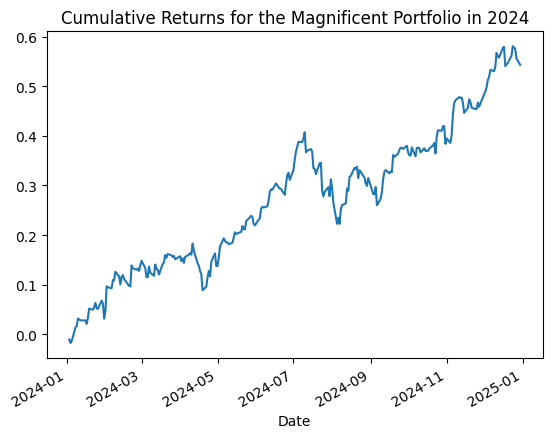

In [13]:
returns['index'].cumsum().plot(title='Cumulative Returns for the Magnificent Portfolio in 2024')

### e) Compute and report the annualized Sharpe ratio for this portfolio in 2024

Assume that the risk-free rate in 2024 was 2% per year

Note: We typically assume that there are 252 trading days per year and so use ```252``` as the annualization factor

In [16]:
m = 252 * returns['index'].mean()
sd = np.sqrt(252) * returns['index'].std()

rf = 0.02  # Assume 2% risk-free rate

sr = (m - rf) / sd

print(f"The portfolio's annualized Sharpe ratio was {sr:.2f}")

The portfolio's annualized Sharpe ratio was 2.19


# Problem 2: Short-Term Reversals

In ```Topic3_CRSP_and_Reversals.ipynb``` notebook we construct a "linear" strategy that traded short-term reversals

When we analyzed this strategy's returns up to December 1995, we found that it earned a Sharpe ratio of 1.70.
- Note: This is before transaction costs. A strategy such as this has very high turnover and would therefore be very expensive to trade as-is

I want you to modify this strategy just a little bit.

- In the current implementation, we take positions on almost every stock
  - We short stocks with positive returns this month and are long those with negative returns
- In the code we generate the -1 to +1 positions on this line:

```

df['position'] = (
    df.groupby(level='date')['ret']  # Group by the 'date' level in the index
    .transform(lambda x: (x.rank(pct=True) - 0.5) * -2)  # Apply percentile rank transformation
)
```

- I want to change this code so that we invest only in assets that have gone up or down substantially, say, ones that belong to the top or bottom deciles
- You can do this by adding just one more line to the code right after we've defined the ```position``` column:

```
df['position'] = df['position'].apply(lambda x: x if np.abs(x) >= 0.9 else 0)
```

- There would be many different ways of doing this one, but ```apply``` is a convenient way of transforming data
  - When you call ```apply()```, you're asking Pandas to do something with each value (in this case)
  - I'm doing a simple lambda function that is not much of a function: it turns the value x itself if |x| >= 0.9 and 0 otherwise
    - The syntax might look a bit weird -- if/else expression of this "short" form are call ternary expressions
    
- Modify the code like this and then run the code up to the point where we compute the strategy's Sharpe ratio

**What is the Sharpe ratio of this modified strategy over the same sample period?**

- Note: I use ```pct=True``` in the code below; in the lectures I switched to computing the percentile manually as (rank - rank.min()) / (rank.max() - rank.min())

Analysis of a strategy: "Short-term reversals (linear weights)"
Start: 1964-01, End: 1995-12
Sharpe ratio: 2.19


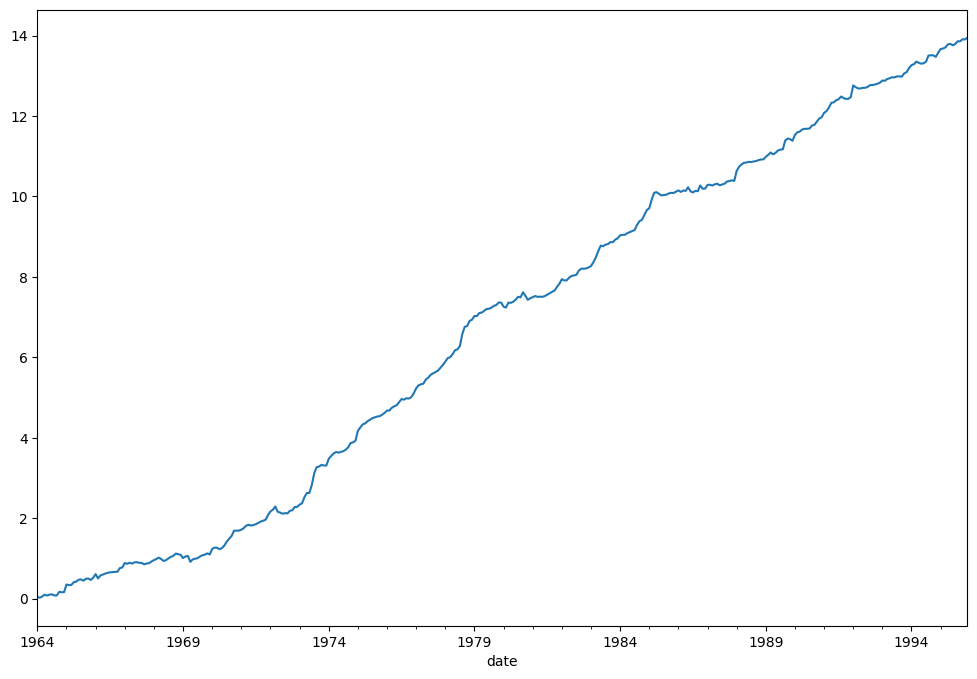

In [18]:
# reload the data
df = pd.read_pickle('/home/jovyan/data/crsp.pkl')

df['position'] = (
    df.groupby(level='date')['ret']  # Group by the 'date' level in the index
    .transform(lambda x: (x.rank(pct=True) - 0.5) * -2)  # Apply percentile rank transformation
)

# NEW LINE
df['position'] = df['position'].apply(lambda x: x if np.abs(x) >= 0.9 else 0)

position = df['position'].unstack(level='permno')
ret = df['ret'].unstack(level='permno')

lagged_position = position.shift(1)

portfolio_return = lagged_position.mul(ret).sum(axis=1, min_count=1)

realized_vol = np.sqrt(12) * portfolio_return.rolling(window=12, min_periods=3).std()
scaled_position = 0.15 * position.div(realized_vol.shift(1), axis=0) 
scaled_lagged_position = scaled_position.shift(1)

strev = scaled_lagged_position.mul(ret).sum(axis=1, min_count=1)

def analyze_returns(r=None, name=None, start_date='1964-01', end_date='2023-09'):
    r = r.loc[start_date:end_date]
    ir = np.sqrt(12) * r.mean() / r.std()
    print(f'Analysis of a strategy: "{name}"')
    print(f'Start: {start_date}, End: {end_date}')
    print(f'Sharpe ratio: {ir:.2f}')
    r.cumsum().plot(figsize=(12,8))
    
analyze_returns(strev, 'Short-term reversals (linear weights)', end_date='1995-12')    